In [ ]:
# !pip install git+https://github.com/dnbaker/ffht 
# !pip install pingouin

In [14]:
import torch
import timeit
import numpy as np
# from hadamard_cuda import hadamard_transform
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pingouin import multivariate_normality
from scipy.linalg import hadamard
import ffht


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def rademacher_sample(M) :
  # MxM Rademacher matrix
  # shape: (M, M)
    return torch.diag(2*(torch.rand(M) > 0.5).int() - 1).float().to(device)

def matrix_D(M,d):
  # d MxM Rademacher matrices. 
  # shape: (d, M, M)
    return torch.stack([rademacher_sample(M) for i in range(d)])

In [28]:
n = 2**8  # needs to be a power of 2 for the ffht package
sigma = 1./np.sqrt(n)
reps = 1000

# z = torch.ones(n, device=device)
z = torch.rand(n, device=device)
# z = z/torch.sqrt(torch.dot(z,z))
z_np = z.cpu().numpy()

D1 = matrix_D(n, reps) # (resp, n,n)
D2 =  matrix_D(n, reps) # (resp, n,n)
D3 =  matrix_D(n, reps) # (resp, n,n)

D1_np = D1.cpu().numpy()
D2_np = D2.cpu().numpy()
D3_np = D3.cpu().numpy()

A = torch.normal(0., sigma, size = (reps, n, n)).to(device)
A_np = A.cpu().numpy()

In [29]:
def base_op_np(D,z):
    return ffht.fht(np.matmul(D,z))
    
def compute_struct_matrix_vector_prod(D3, D2, D1, z, base_op):
        
    # Compute HD3*z
    y = base_op(D3,z) # (batch, d, n, 1)
    # Compute HD2*HD3z
    y = base_op(D2,y) # (batch, d, n, 1)
    # Compute HD1*HD2*HD3z
    y = base_op(D1,y) # (batch, d, n, 1)
    
    factor = 1./(n*np.sqrt(n))
    
    return factor*y

In [30]:
times = []
results_hadamard_np = np.zeros((reps, n))

t1 = timeit.default_timer()

for i in range(reps):
    # res_np = H@D1[i]@H@D2[i]@H@D3[i]@z_np
    res_np = compute_struct_matrix_vector_prod(D3_np[i], D2_np[i], D1_np[i], z_np, base_op_np)
    results_hadamard_np[i] = res_np
    times.append(timeit.default_timer()-t1)
print('Mean time:', np.mean(times))
# print('Result vector:', res_np)

Mean time: 0.04620100371018498


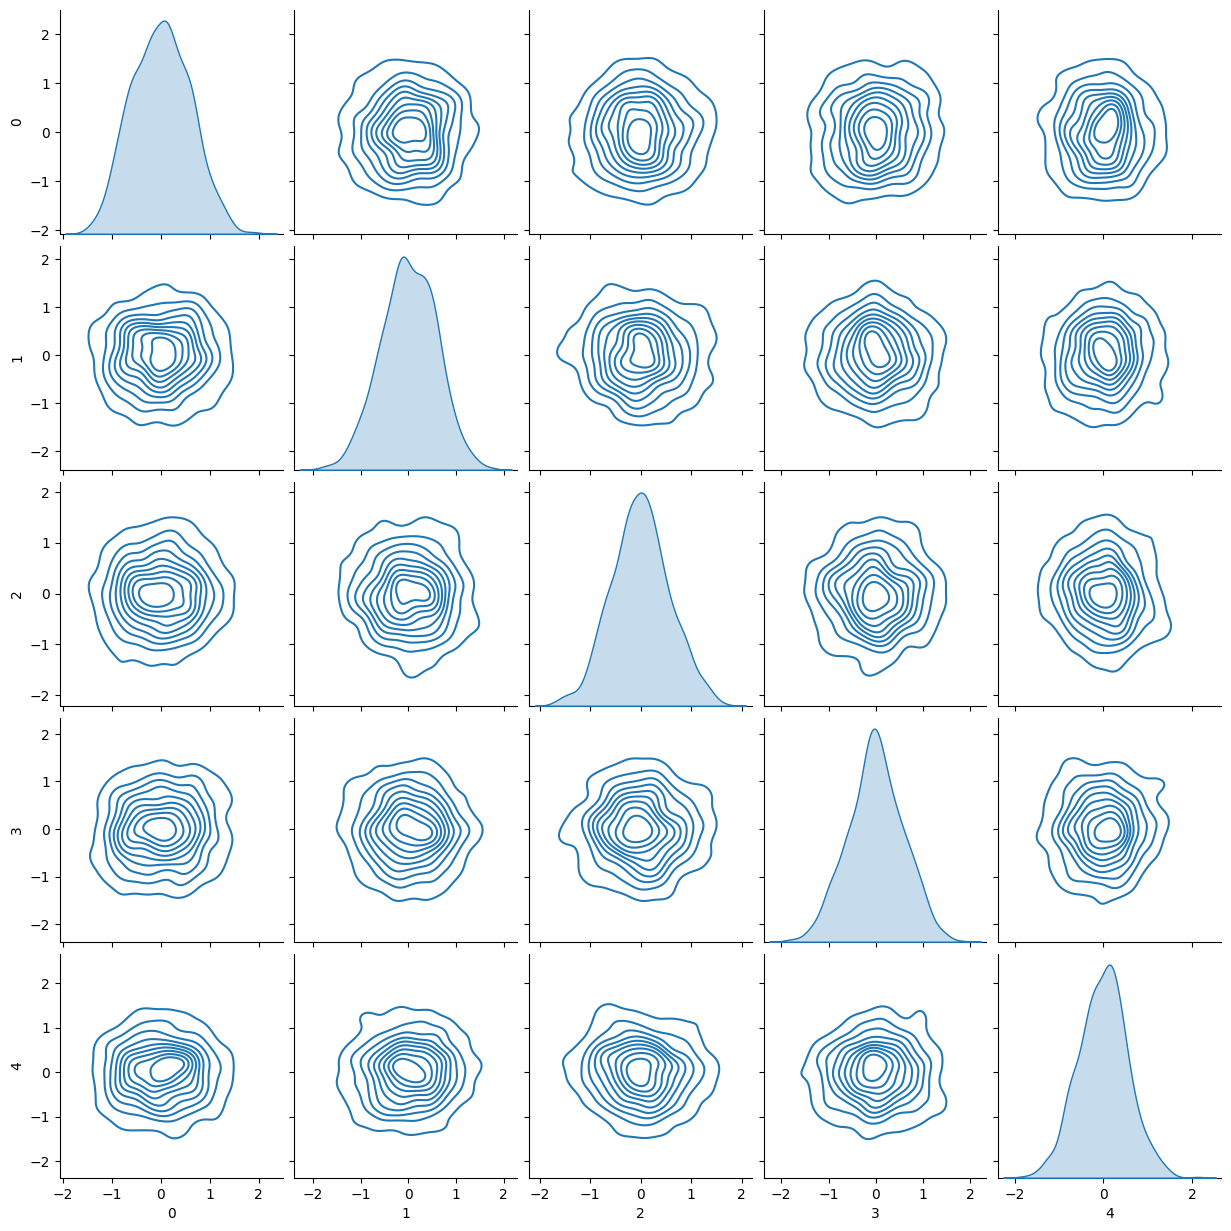

In [31]:
coordinates = np.sort(np.random.choice(n,5,replace=False))

sns.pairplot(pd.DataFrame(results_hadamard_np[:,coordinates]), kind="kde")
plt.show()

In [32]:
multivariate_normality(results_hadamard_np[:,coordinates], alpha=.05)

HZResults(hz=0.9639001014021091, pval=0.36364561147709606, normal=True)

<Axes: >

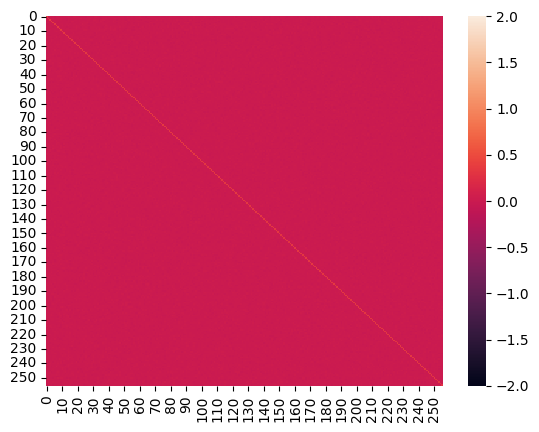

In [33]:
sns.heatmap(np.cov(results_hadamard_np.T[:,:]),vmin=-2, vmax=2)